<a href="https://colab.research.google.com/github/ItaiKaplan/Reinforcement-learning/blob/main/Reinforcements_learning_mid_semester_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid-semester assignment - Reinforcements learning 


Notebook by Itai Kaplan


## Installs

In [1]:
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 976 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (724 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155639 files and directories currently instal

## Imports

In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()



if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1



"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## MazeEnv
The cell below contains the configuration of the maze environment. No need to make changes here.

In [4]:

class MazeEnv(gym.Env):
    metadata = {
        "render.modes": ["human", "rgb_array"],
    }

    ACTION = ["N", "S", "E", "W"]

    def __init__(self, maze_file=None, maze_size=None, mode=None, enable_render=True):

        self.viewer = None
        self.enable_render = enable_render

        if maze_file:
            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%s)" % maze_file,
                                        maze_file_path=maze_file,
                                        screen_size=(640, 640), 
                                        enable_render=enable_render)
        elif maze_size:
            if mode == "plus":
                has_loops = True
                num_portals = int(round(min(maze_size)/3))
            else:
                has_loops = False
                num_portals = 0

            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%d x %d)" % maze_size,
                                        maze_size=maze_size, screen_size=(640, 640),
                                        has_loops=has_loops, num_portals=num_portals,
                                        enable_render=enable_render)
        else:
            raise AttributeError("One must supply either a maze_file path (str) or the maze_size (tuple of length 2)")

        self.maze_size = self.maze_view.maze_size

        # forward or backward in each dimension
        self.action_space = spaces.Discrete(2*len(self.maze_size))

        # observation is the x, y coordinate of the grid
        low = np.zeros(len(self.maze_size), dtype=int)
        high =  np.array(self.maze_size, dtype=int) - np.ones(len(self.maze_size), dtype=int)
        self.observation_space = spaces.Box(low, high, dtype=np.int64)

        # initial condition
        self.state = None
        self.steps_beyond_done = None

        # Simulation related variables.
        self.seed()
        self.reset()

        # Just need to initialize the relevant attributes
        self.configure()

    def __del__(self):
        if self.enable_render is True:
            self.maze_view.quit_game()

    def configure(self, display=None):
        self.display = display

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        if isinstance(action, int):

            self.maze_view.move_robot(self.ACTION[action])
        else:
            self.maze_view.move_robot(action)

        if np.array_equal(self.maze_view.robot, self.maze_view.goal):
            reward = 2
            done = True
        else:
            reward = -0.1/(self.maze_size[0]*self.maze_size[1])
            done = False

        self.state = self.maze_view.robot

        info = {}

        return self.state, reward, done, info

    def reset(self):
        self.maze_view.reset_robot()
        self.state = np.zeros(2)
        self.steps_beyond_done = None
        self.done = False
        return self.state

    def is_game_over(self):
        return self.maze_view.game_over

    def render(self, mode="human", close=False):
        if close:
            self.maze_view.quit_game()

        return self.maze_view.update(mode)



class MazeView2D:

    def __init__(self, maze_name="Maze2D", maze_file_path=None,
                 maze_size=(30, 30), screen_size=(600, 600),
                 has_loops=False, num_portals=0, enable_render=True):

        # PyGame configurations
        pygame.init()
        pygame.display.set_caption(maze_name)
        self.clock = pygame.time.Clock()
        self.__game_over = False
        self.__enable_render = enable_render

        # Load a maze
        if maze_file_path is None:
            self.__maze = Maze(maze_size=maze_size, has_loops=has_loops, num_portals=num_portals)
        else:
            if not os.path.exists(maze_file_path):
                dir_path = os.path.dirname(os.path.abspath(__file__))
                rel_path = os.path.join(dir_path, "maze_samples", maze_file_path)
                if os.path.exists(rel_path):
                    maze_file_path = rel_path
                else:
                    raise FileExistsError("Cannot find %s." % maze_file_path)
            self.__maze = Maze(maze_cells=Maze.load_maze(maze_file_path))

        self.maze_size = self.__maze.maze_size
        if self.__enable_render is True:
            # to show the right and bottom border
            self.screen = pygame.display.set_mode(screen_size)
            self.__screen_size = tuple(map(sum, zip(screen_size, (-1, -1))))

        # Set the starting point
        self.__entrance = np.zeros(2, dtype=int)

        # Set the Goal
        self.__goal = np.array(self.maze_size) - np.array((1, 1))

        # Create the Robot
        self.__robot = self.entrance

        self.__fst_reward_cell = np.array([5,19])

        self.__scnd_reward_cell = np.array([20,26])
        

        if self.__enable_render is True:
            # Create a background
            self.background = pygame.Surface(self.screen.get_size()).convert()
            self.background.fill((255, 255, 255))

            # Create a layer for the maze
            self.maze_layer = pygame.Surface(self.screen.get_size()).convert_alpha()
            self.maze_layer.fill((0, 0, 0, 0,))

            # show the maze
            self.__draw_maze()

            # show the portals
            self.__draw_portals()

            # show the robot
            self.__draw_robot()

            # show the entrance
            self.__draw_entrance()

            # show the goal
            self.__draw_goal()

            if self.maze_size[0] > 15:
              self.__draw_reward_cells()


    def update(self, mode="human"):
        try:
            img_output = self.__view_update(mode)
            self.__controller_update()
        except Exception as e:
            self.__game_over = True
            self.quit_game()
            raise e
        else:
            return img_output

    def quit_game(self):
        try:
            self.__game_over = True
            if self.__enable_render is True:
                pygame.display.quit()
            pygame.quit()
        except Exception:
            pass

    def move_robot(self, dir):
        if dir not in self.__maze.COMPASS.keys():
            raise ValueError("dir cannot be %s. The only valid dirs are %s."
                             % (str(dir), str(self.__maze.COMPASS.keys())))

        if self.__maze.is_open(self.__robot, dir):

            # update the drawing
            self.__draw_robot(transparency=0)

            # move the robot
            self.__robot += np.array(self.__maze.COMPASS[dir])
            # if it's in a portal afterward
            if self.maze.is_portal(self.robot):
                self.__robot = np.array(self.maze.get_portal(tuple(self.robot)).teleport(tuple(self.robot)))
            self.__draw_robot(transparency=255)

    def reset_robot(self):

        self.__draw_robot(transparency=0)
        self.__robot = np.zeros(2, dtype=int)
        self.__draw_robot(transparency=255)

    def __controller_update(self):
        if not self.__game_over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.__game_over = True
                    self.quit_game()

    def __view_update(self, mode="human"):
        if not self.__game_over:
            # update the robot's position
            self.__draw_entrance()
            self.__draw_goal()
            if self.maze_size[0] > 15:
              self.__draw_reward_cells()
            self.__draw_portals()
            self.__draw_robot()


            # update the screen
            self.screen.blit(self.background, (0, 0))
            self.screen.blit(self.maze_layer,(0, 0))

            if mode == "human":
                pygame.display.flip()

            return np.flipud(np.rot90(pygame.surfarray.array3d(pygame.display.get_surface())))

    def __draw_maze(self):
        
        if self.__enable_render is False:
            return
        
        line_colour = (0, 0, 0, 255)

        # drawing the horizontal lines
        for y in range(self.maze.MAZE_H + 1):
            pygame.draw.line(self.maze_layer, line_colour, (0, y * self.CELL_H),
                             (self.SCREEN_W, y * self.CELL_H))

        # drawing the vertical lines
        for x in range(self.maze.MAZE_W + 1):
            pygame.draw.line(self.maze_layer, line_colour, (x * self.CELL_W, 0),
                             (x * self.CELL_W, self.SCREEN_H))

        # breaking the walls
        for x in range(len(self.maze.maze_cells)):
            for y in range (len(self.maze.maze_cells[x])):
                # check the which walls are open in each cell
                walls_status = self.maze.get_walls_status(self.maze.maze_cells[x, y])
                dirs = ""
                for dir, open in walls_status.items():
                    if open:
                        dirs += dir
                self.__cover_walls(x, y, dirs)

    def __cover_walls(self, x, y, dirs, colour=(0, 0, 255, 15)):

        if self.__enable_render is False:
            return
        
        dx = x * self.CELL_W
        dy = y * self.CELL_H

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        for dir in dirs:
            if dir == "S":
                line_head = (dx + 1, dy + self.CELL_H)
                line_tail = (dx + self.CELL_W - 1, dy + self.CELL_H)
            elif dir == "N":
                line_head = (dx + 1, dy)
                line_tail = (dx + self.CELL_W - 1, dy)
            elif dir == "W":
                line_head = (dx, dy + 1)
                line_tail = (dx, dy + self.CELL_H - 1)
            elif dir == "E":
                line_head = (dx + self.CELL_W, dy + 1)
                line_tail = (dx + self.CELL_W, dy + self.CELL_H - 1)
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            pygame.draw.line(self.maze_layer, colour, line_head, line_tail)

    def __draw_robot(self, colour=(0, 0, 150), transparency=255):

        if self.__enable_render is False:
            return
        
        x = int(self.__robot[0] * self.CELL_W + self.CELL_W * 0.5 + 0.5)
        y = int(self.__robot[1] * self.CELL_H + self.CELL_H * 0.5 + 0.5)
        r = int(min(self.CELL_W, self.CELL_H)/5 + 0.5)

        pygame.draw.circle(self.maze_layer, colour + (transparency,), (x, y), r)

    def __draw_entrance(self, colour=(0, 0, 150), transparency=235):

        self.__colour_cell(self.entrance, colour=colour, transparency=transparency)

    def __draw_goal(self, colour=(150, 0, 0), transparency=235):

        self.__colour_cell(self.goal, colour=colour, transparency=transparency)

    
    def __draw_reward_cells(self, colour=(0, 150, 0), transparency=235):

      self.__colour_cell(self.fst_reward_cell, colour=colour, transparency=transparency)
      self.__colour_cell(self.scnd_reward_cell, colour=colour, transparency=transparency)


    def __draw_portals(self, transparency=160):

        if self.__enable_render is False:
            return
        
        colour_range = np.linspace(0, 255, len(self.maze.portals), dtype=int)
        colour_i = 0
        for portal in self.maze.portals:
            colour = ((100 - colour_range[colour_i])% 255, colour_range[colour_i], 0)
            colour_i += 1
            for location in portal.locations:
                self.__colour_cell(location, colour=colour, transparency=transparency)

    def __colour_cell(self, cell, colour, transparency):

        if self.__enable_render is False:
            return

        if not (isinstance(cell, (list, tuple, np.ndarray)) and len(cell) == 2):
            raise TypeError("cell must a be a tuple, list, or numpy array of size 2")

        x = int(cell[0] * self.CELL_W + 0.5 + 1)
        y = int(cell[1] * self.CELL_H + 0.5 + 1)
        w = int(self.CELL_W + 0.5 - 1)
        h = int(self.CELL_H + 0.5 - 1)
        pygame.draw.rect(self.maze_layer, colour + (transparency,), (x, y, w, h))

    @property
    def maze(self):
        return self.__maze

    @property
    def robot(self):
        return self.__robot

    @property
    def entrance(self):
        return self.__entrance

    @property
    def goal(self):
        return self.__goal

    @property
    def fst_reward_cell(self):
        return self.__fst_reward_cell

    @property
    def scnd_reward_cell(self):
        return self.__scnd_reward_cell

    @property
    def game_over(self):
        return self.__game_over

    @property
    def SCREEN_SIZE(self):
        return tuple(self.__screen_size)

    @property
    def SCREEN_W(self):
        return int(self.SCREEN_SIZE[0])

    @property
    def SCREEN_H(self):
        return int(self.SCREEN_SIZE[1])

    @property
    def CELL_W(self):
        return float(self.SCREEN_W) / float(self.maze.MAZE_W)

    @property
    def CELL_H(self):
        return float(self.SCREEN_H) / float(self.maze.MAZE_H)

class Maze:

    COMPASS = {
        "N": (0, -1),
        "E": (1, 0),
        "S": (0, 1),
        "W": (-1, 0)
    }

    def __init__(self, maze_cells=None, maze_size=(10,10), has_loops=True, num_portals=0):

        # maze member variables
        self.maze_cells = maze_cells
        self.has_loops = has_loops
        self.__portals_dict = dict()
        self.__portals = []
        self.num_portals = num_portals

        # Use existing one if exists
        if self.maze_cells is not None:
            if isinstance(self.maze_cells, (np.ndarray, np.generic)) and len(self.maze_cells.shape) == 2:
                self.maze_size = tuple(maze_cells.shape)
            else:
                raise ValueError("maze_cells must be a 2D NumPy array.")
        # Otherwise, generate a random one
        else:
            raise ValueError("Please upload the maze you downloaded in the submission box!")
         

    def save_maze(self, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(os.path.dirname(file_path)):
            raise ValueError("Cannot find the directory for %s." % file_path)

        else:
            np.save(file_path, self.maze_cells, allow_pickle=False, fix_imports=True)

    @classmethod
    def load_maze(cls, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(file_path):
            raise ValueError("Cannot find %s." % file_path)

        else:
            return np.load(file_path, allow_pickle=False, fix_imports=True)

    def __break_random_walls(self, percent):
        # find some random cells to break
        num_cells = int(round(self.MAZE_H*self.MAZE_W*percent))
        cell_ids = random.sample(range(self.MAZE_W*self.MAZE_H), num_cells)

        # for each of those walls
        for cell_id in cell_ids:
            x = cell_id % self.MAZE_H
            y = int(cell_id/self.MAZE_H)

            # randomize the compass order
            dirs = random.sample(list(self.COMPASS.keys()), len(self.COMPASS))
            for dir in dirs:
                # break the wall if it's not already open
                if self.is_breakable((x, y), dir):
                    self.maze_cells[x, y] = self.__break_walls(self.maze_cells[x, y], dir)
                    break

    def __set_random_portals(self, num_portal_sets, set_size=2):
        # find some random cells to break
        num_portal_sets = int(num_portal_sets)
        set_size = int(set_size)

        # limit the maximum number of portal sets to the number of cells available.
        max_portal_sets = int(self.MAZE_W * self.MAZE_H / set_size)
        num_portal_sets = min(max_portal_sets, num_portal_sets)

        # the first and last cells are reserved
        cell_ids = random.sample(range(1, self.MAZE_W * self.MAZE_H - 1), num_portal_sets*set_size)

        for i in range(num_portal_sets):
            # sample the set_size number of sell
            portal_cell_ids = random.sample(cell_ids, set_size)
            portal_locations = []
            for portal_cell_id in portal_cell_ids:
                # remove the cell from the set of potential cell_ids
                cell_ids.pop(cell_ids.index(portal_cell_id))
                # convert portal ids to location
                x = portal_cell_id % self.MAZE_H
                y = int(portal_cell_id / self.MAZE_H)
                portal_locations.append((x,y))
            # append the new portal to the maze
            portal = Portal(*portal_locations)
            self.__portals.append(portal)

            # create a dictionary of portals
            for portal_location in portal_locations:
                self.__portals_dict[portal_location] = portal

    def is_open(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        # if cell is still within bounds after the move
        if self.is_within_bound(x1, y1):
            # check if the wall is opened
            this_wall = bool(self.get_walls_status(self.maze_cells[cell_id[0], cell_id[1]])[dir])
            other_wall = bool(self.get_walls_status(self.maze_cells[x1, y1])[self.__get_opposite_wall(dir)])
            return this_wall or other_wall
        return False

    def is_breakable(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        return not self.is_open(cell_id, dir) and self.is_within_bound(x1, y1)

    def is_within_bound(self, x, y):
        # true if cell is still within bounds after the move
        return 0 <= x < self.MAZE_W and 0 <= y < self.MAZE_H

    def is_portal(self, cell):
        return tuple(cell) in self.__portals_dict

    @property
    def portals(self):
        return tuple(self.__portals)

    def get_portal(self, cell):
        if cell in self.__portals_dict:
            return self.__portals_dict[cell]
        return None

    @property
    def MAZE_W(self):
        return int(self.maze_size[0])

    @property
    def MAZE_H(self):
        return int(self.maze_size[1])

    @classmethod
    def get_walls_status(cls, cell):
        walls = {
            "N" : (cell & 0x1) >> 0,
            "E" : (cell & 0x2) >> 1,
            "S" : (cell & 0x4) >> 2,
            "W" : (cell & 0x8) >> 3,
        }
        return walls

    @classmethod
    def all_walls_intact(cls, cell):
        return cell & 0xF == 0

    @classmethod
    def num_walls_broken(cls, cell):
        walls = cls.get_walls_status(cell)
        num_broken = 0
        for wall_broken in walls.values():
            num_broken += wall_broken
        return num_broken

    @classmethod
    def __break_walls(cls, cell, dirs):
        if "N" in dirs:
            cell |= 0x1
        if "E" in dirs:
            cell |= 0x2
        if "S" in dirs:
            cell |= 0x4
        if "W" in dirs:
            cell |= 0x8
        return cell

    @classmethod
    def __get_opposite_wall(cls, dirs):

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        opposite_dirs = ""

        for dir in dirs:
            if dir == "N":
                opposite_dir = "S"
            elif dir == "S":
                opposite_dir = "N"
            elif dir == "E":
                opposite_dir = "W"
            elif dir == "W":
                opposite_dir = "E"
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            opposite_dirs += opposite_dir

        return opposite_dirs
        
class MazeEnvSample15x15(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample15x15, self).__init__(maze_file="/content/maze2d_15x15.npy", enable_render=enable_render)


class MazeEnvSample30x30(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample30x30, self).__init__(maze_file="/content/maze2d_30x30.npy", enable_render=enable_render)



### Upload the maze files
Upload the maze files you downloaded in the submission box

In [5]:
from google.colab import files
print('Please upload the maze2d_15x15 file')
maze2d_15x15 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_15x15)[0], length=len(list(maze2d_15x15)[0])))

print('\nPlease upload the maze2d_30x30 file')
maze2d_30x30 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_30x30)[0], length=len(list(maze2d_30x30)[0])))

Please upload the maze2d_15x15 file


MessageError: ignored

## Environment 
**If the first time you run the cell an error appears Try to run the cell again.**

---

In [ ]:
maze2d_15x15 = open('/content/maze2d_15x15.npy')
maze2d_30x30 = open('/content/maze2d_30x30.npy')

# Stochastic model
We defined the stochastic move as a separate function, and not as part of the pre-defined environment "step". We did so for two reasons, one - so we can control when we want to use a stochastic model and when we want to use a deterministic one (for testing purposes), and two - we wanted to leave the pre-defined model with as few changes as possible (in fact, the only changes we did in the environment is marking the reward cells in green, and adjusting the rewards for each cell).  

In [ ]:
def stochastic_move(action):
  p = np.full((env.action_space.n,), (0.1/(env.action_space.n - 1)))
  p[action] = 0.9
  after_stochastic_action = np.random.choice(np.arange(env.action_space.n), p=p)
  return int(after_stochastic_action)

# Monte Carlo Epsilon Greedy Algorithm

We did a lot of experiments on the Monte Carlo algorithm, to receive the best results in minimum time. 
At first, we tried to implement it with the Exploring start technic, but we found that with the Epsilon greedy with epsilon soft algorithm we converge to the solution faster. In both cases, the every visit method was also converging better (in a noticeable difference).

As to the implementation, we defined two main methods. One to run each iteration based on the Q-table we generated so far (Choosing the next move using the epsilon soft method). And the second is to run each episode and update the Q-table according to each iteration collected data.
Note that we decayed our epsilon - each time we reached the goal - the decayed the epsilon based on the number of iterations we performed to reach the goal. The idea was - if we reached the goal quickly we want to decrease epsilon more.

In [ ]:
class MonteCarloEpsilonGreedy:
  def __init__(self, env, epsilon, gamma, number_iter_per_episode=10000):
    self.env = env
    self.epsilon = epsilon
    self.gamma = gamma
    self.Q = np.zeros((self.env.maze_size[0], self.env.maze_size[1], self.env.action_space.n))
    self.k = np.zeros((self.env.maze_size[0], self.env.maze_size[1], self.env.action_space.n), dtype=int)
    self.best_Q = self.Q.copy()
    self.best_time = number_iter_per_episode
    self.done_counter = dict()
    self.rewards = []
    self.number_iter_per_episode = number_iter_per_episode

  def epsilon_choose(self, action):
    p = np.full((self.env.action_space.n,), self.epsilon/len(self.env.ACTION))
    p[action] = 1-self.epsilon + self.epsilon/len(self.env.ACTION) 
    after_epsilon_action = np.random.choice(np.arange(self.env.action_space.n, dtype=int), p=p)
    return int(after_epsilon_action)
    
  def run_iteration(self, iter_number):
    self.env.reset()
    episode_data = []
    done = self.env.done
    i = 0
    rewards_sum = 0 
    while not done and i < iter_number:
      state = self.env.state.astype(int)     
      max_indices = np.argwhere(np.max(self.Q[state[0], state[1],:]) == self.Q[state[0], state[1],:])
      max_indices = np.reshape(max_indices, (max_indices.shape[0],))
      action = np.random.choice(max_indices)
      after_epsilon_action = self.epsilon_choose(action)
      actual_move = stochastic_move(after_epsilon_action)
      observation, reward, done, _ = self.env.step(actual_move)
      rewards_sum += reward
      episode_data.append([state, actual_move, reward])
      i += 1

    if done:
      if i in self.done_counter.keys():
        self.done_counter[i] += 1
      else:
        self.done_counter[i] = 1
      if i < self.best_time:
        self.best_time = i
        self.best_Q = self.Q.copy()

      print("Reached to final point, number of iterations:" + str(i))
      self.epsilon = max((self.epsilon * ((i-1) / i)), 0.1)

    self.rewards.append(rewards_sum)
    return episode_data

  def run_episode(self, number_of_episodes):
    for episode in range(number_of_episodes):
      print(f'Episode number: {episode}')
      episode_data = self.run_iteration(self.number_iter_per_episode)
      G = 0
      for state, a, r in reversed(episode_data):
        G = (G * self.gamma) + r
        self.k[state[0], state[1], a] += 1
        self.Q[state[0], state[1], a] = self.Q[state[0], state[1], a] + (1/self.k[state[0], state[1], a])*(G - self.Q[state[0], state[1], a])


# Running example - On policy - Every Visit - Monte Carlo Control - Epslion soft



In [ ]:
env = MazeEnvSample15x15() 
env.reset()
# After a lot of experiments this epsilon performs best - after the goal is reached a few times -
# it decreases to 0.1 quite quickly
epsilon = 0.2 
gamma = 0.8


In [ ]:
MC = MonteCarloEpsilonGreedy(env, epsilon, gamma)

**First 200 episodes**

In [ ]:
MC.run_episode(200)

Episode number: 0
Reached to final point, number of iterations:938
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Reached to final point, number of iterations:9377
Episode number: 5
Reached to final point, number of iterations:665
Episode number: 6
Reached to final point, number of iterations:568
Episode number: 7
Reached to final point, number of iterations:484
Episode number: 8
Reached to final point, number of iterations:446
Episode number: 9
Reached to final point, number of iterations:99
Episode number: 10
Reached to final point, number of iterations:220
Episode number: 11
Reached to final point, number of iterations:2700
Episode number: 12
Reached to final point, number of iterations:791
Episode number: 13
Reached to final point, number of iterations:685
Episode number: 14
Reached to final point, number of iterations:124
Episode number: 15
Reached to final point, number of iterations:188
Episode number: 16
Reached to final point, number of iterations:2305

iteration: 46, action: 1,  observation: [14 14], reward: 2, done: True


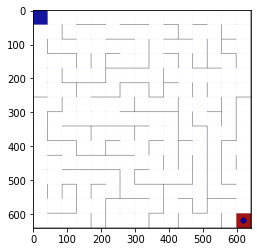

In [ ]:
env = MazeEnvSample15x15() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
print(done)
iter = 0
while not done:
  iter +=1
  state = env.state.astype(int)
  max_indices = np.argwhere(np.max(MC.best_Q[state[0], state[1],:]) == MC.best_Q[state[0], state[1],:])
  max_indices = np.reshape(max_indices, (max_indices.shape[0],))
  action = np.random.choice(max_indices)
  actual_move = stochastic_move(action)
  observation, reward, done, _ = env.step(actual_move)

  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

In [ ]:
env.close()
show_video()

**Final 200 episodes**

In [ ]:
MC.run_episode(200)

Episode number: 0
Reached to final point, number of iterations:41
Episode number: 1
Reached to final point, number of iterations:38
Episode number: 2
Reached to final point, number of iterations:41
Episode number: 3
Reached to final point, number of iterations:57
Episode number: 4
Reached to final point, number of iterations:38
Episode number: 5
Reached to final point, number of iterations:33
Episode number: 6
Reached to final point, number of iterations:41
Episode number: 7
Reached to final point, number of iterations:36
Episode number: 8
Reached to final point, number of iterations:39
Episode number: 9
Reached to final point, number of iterations:48
Episode number: 10
Reached to final point, number of iterations:46
Episode number: 11
Reached to final point, number of iterations:41
Episode number: 12
Reached to final point, number of iterations:39
Episode number: 13
Reached to final point, number of iterations:51
Episode number: 14
Reached to final point, number of iterations:42
Episo

iteration: 37, action: 1,  observation: [14 14], reward: 2, done: True


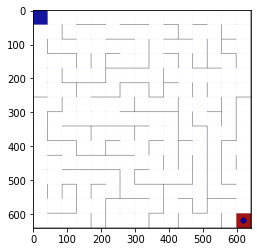

In [ ]:
env = MazeEnvSample15x15() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
print(done)
iter = 0
while not done:
  iter +=1
  state = env.state.astype(int)
  max_indices = np.argwhere(np.max(MC.best_Q[state[0], state[1],:]) == MC.best_Q[state[0], state[1],:])
  max_indices = np.reshape(max_indices, (max_indices.shape[0],))
  action = np.random.choice(max_indices)
  actual_move = stochastic_move(action)
  observation, reward, done, _ = env.step(actual_move)

  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

In [ ]:
env.close()
show_video()

**Convergence graph**

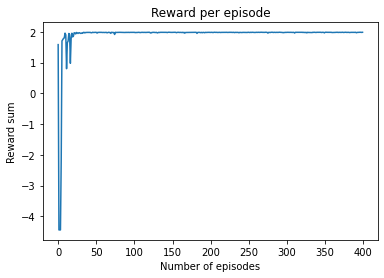

In [ ]:
episodes = [i for i in range(len(MC.rewards))]
plt.plot(episodes, MC.rewards)
plt.plot()

plt.xlabel("Number of episodes")
plt.ylabel("Reward sum")
plt.title("Reward per episode")
plt.show()

# Q-Learning 15x15
This implementation was pretty straightforward, as it converged very well on our first try - which was following the lecture notes.

In [ ]:
class Q_learning:
  def __init__(self, env, epsilon, alpha, gamma, number_iter_per_episode=5000):
    self.env = env
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.Q = self.Q = np.zeros((self.env.maze_size[0], self.env.maze_size[1], self.env.action_space.n))  
    self.best_Q = self.Q.copy()
    self.best_time = number_iter_per_episode
    self.done_counter = dict()
    self.number_iter_per_episode = number_iter_per_episode  
    self.rewards = []

  def epsilon_choose(self, action):
    p = np.full((self.env.action_space.n,), self.epsilon/len(self.env.ACTION))
    p[action] = 1-self.epsilon + self.epsilon/len(self.env.ACTION) 
    after_epsilon_action = np.random.choice(np.arange(self.env.action_space.n, dtype=int), p=p)
    return int(after_epsilon_action)

  def run_iteration(self, iter_number):
    self.env.reset()
    done = self.env.done
    rewards_sum = 0
    i = 0
    while not done and i < iter_number:
      state = self.env.state.astype(int)
      max_indices = np.argwhere(np.max(self.Q[state[0], state[1],:]) == self.Q[state[0], state[1],:])
      max_indices = np.reshape(max_indices, (max_indices.shape[0],))
      action = np.random.choice(max_indices)
      after_epsilon_action = self.epsilon_choose(action)
      actual_move = stochastic_move(after_epsilon_action)
      observation, reward, done, _ = self.env.step(actual_move)
      rewards_sum += reward
      # Update Q-table
      self.Q[state[0], state[1], actual_move] = self.Q[state[0], state[1], actual_move] + self.alpha * (reward + self.gamma * np.max(self.Q[observation[0], observation[1],:]) - self.Q[state[0], state[1], actual_move])
      i += 1
    if done:
      if i in self.done_counter.keys():
        self.done_counter[i] += 1
      else:
        self.done_counter[i] = 1
      if i < self.best_time:
        self.best_time = i
        self.best_Q = self.Q.copy()
      print("Reached to final point, number of iterations:" + str(i))
      # self.alpha = max((self.alpha * ((i-1) / i)), 0.1)
    self.rewards.append(rewards_sum)
    return 

  def run_episode(self, number_of_episodes):
    for episode in range(number_of_episodes):
      print(f'Episode number: {episode}')
      self.run_iteration(self.number_iter_per_episode)

# Running Q-Learning - Off Policy - Temporal Difference


**Alpha** - We choose a relatively big alpha which decreases over time - also after playing with the model with different alphas and choosing the best one

In [ ]:
env = MazeEnvSample15x15()  
env.reset()
epsilon = 0.1
alpha = 0.5
gamma = 0.9

In [ ]:
QL = Q_learning(env,epsilon, alpha, gamma)

**First 100 episodes**

In [ ]:
QL.run_episode(100)

Episode number: 0
Reached to final point, number of iterations:618
Episode number: 1
Reached to final point, number of iterations:1972
Episode number: 2
Reached to final point, number of iterations:355
Episode number: 3
Reached to final point, number of iterations:2050
Episode number: 4
Reached to final point, number of iterations:388
Episode number: 5
Reached to final point, number of iterations:475
Episode number: 6
Reached to final point, number of iterations:423
Episode number: 7
Reached to final point, number of iterations:777
Episode number: 8
Reached to final point, number of iterations:1290
Episode number: 9
Reached to final point, number of iterations:322
Episode number: 10
Reached to final point, number of iterations:383
Episode number: 11
Reached to final point, number of iterations:617
Episode number: 12
Reached to final point, number of iterations:582
Episode number: 13
Reached to final point, number of iterations:171
Episode number: 14
Reached to final point, number of it

iteration: 37, action: 1,  observation: [14 14], reward: 2, done: True


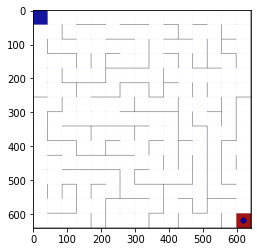

In [ ]:
env = MazeEnvSample15x15() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
print(done)
iter = 0
while not done:
  iter +=1
  state = env.state.astype(int)
  max_indices = np.argwhere(np.max(QL.best_Q[state[0], state[1],:]) == QL.best_Q[state[0], state[1],:])
  max_indices = np.reshape(max_indices, (max_indices.shape[0],))
  action = np.random.choice(max_indices)
  actual_move = stochastic_move(action)
  observation, reward, done, _ = env.step(actual_move)

  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

In [ ]:
env.close()
show_video()

**Final 100 episodes**

In [ ]:
QL.run_episode(100)

Episode number: 0
Reached to final point, number of iterations:36
Episode number: 1
Reached to final point, number of iterations:39
Episode number: 2
Reached to final point, number of iterations:37
Episode number: 3
Reached to final point, number of iterations:55
Episode number: 4
Reached to final point, number of iterations:41
Episode number: 5
Reached to final point, number of iterations:38
Episode number: 6
Reached to final point, number of iterations:44
Episode number: 7
Reached to final point, number of iterations:40
Episode number: 8
Reached to final point, number of iterations:39
Episode number: 9
Reached to final point, number of iterations:38
Episode number: 10
Reached to final point, number of iterations:33
Episode number: 11
Reached to final point, number of iterations:41
Episode number: 12
Reached to final point, number of iterations:35
Episode number: 13
Reached to final point, number of iterations:42
Episode number: 14
Reached to final point, number of iterations:36
Episo

iteration: 34, action: 1,  observation: [14 14], reward: 2, done: True


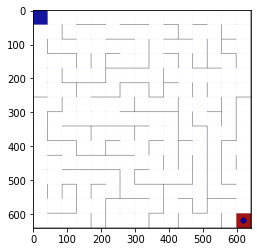

In [ ]:
env = MazeEnvSample15x15() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
print(done)
iter = 0
while not done:
  iter +=1
  state = env.state.astype(int)
  max_indices = np.argwhere(np.max(QL.best_Q[state[0], state[1],:]) == QL.best_Q[state[0], state[1],:])
  max_indices = np.reshape(max_indices, (max_indices.shape[0],))
  action = np.random.choice(max_indices)
  actual_move = stochastic_move(action)
  observation, reward, done, _ = env.step(actual_move)

  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

In [ ]:
env.close()
show_video()

**Convergence graph**

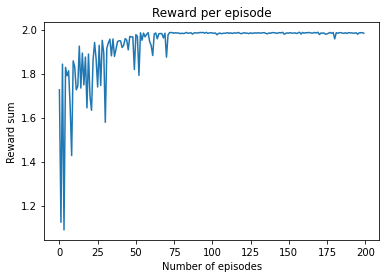

In [ ]:
episodes = [i for i in range(len(QL.rewards))]
plt.plot(episodes, QL.rewards)
plt.plot()

plt.xlabel("Number of episodes")
plt.ylabel("Reward sum")
plt.title("Reward per episode")
plt.show()

# 30x30 Enviorment
As we approached this problem we knew we wanted to use our Q-learning algorithm to solve it. On the 15x15 Environment, our algorithm worked pretty quickly and we assumed that even without adding the reward cells we could solve it rather fast - and so it did, usually, in about 1500 episodes our algorithm converges to the optimal solution. 
when we started exploring the reward cells we choose two cells that we saw that our 15x15 algorithm went through, and was somewhat in the ⅓ and ⅔ sections of its way to the goal. When choosing the amount of reward for each cell we did some crucial mistakes. First, we gave a Non-negative reward (We tried 1 and then 0) which of course resulted in the agent getting “stuck” at the reward cells (we added a video). Then we tried to divide the negative rewards by 2, but to our surprise, this also slowed the convergence - while the agent did not “stuck” at the reward cells, he did like to spend some time around them before continuing to the goal.
We then decided just to gently guide the agent to the reward cells, this is to make sure he chooses the best route we want him to take (in the 30x30 case there are few "best" routes). We did so by lowering the penalty in the specific cells by a very very small amount. 

In [ ]:
class Q_learning_30x30:
  def __init__(self, env, epsilon, alpha, gamma, number_iter_per_episode=5000):
    self.env = env
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.Q = self.Q = np.zeros((self.env.maze_size[0], self.env.maze_size[1], self.env.action_space.n))  
    self.best_Q = self.Q.copy()
    self.best_time = number_iter_per_episode
    self.done_counter = dict()
    self.number_iter_per_episode = number_iter_per_episode  
    self.rewards = []

  def epsilon_choose(self, action):
    p = np.full((self.env.action_space.n,), self.epsilon/len(self.env.ACTION))
    p[action] = 1-self.epsilon + self.epsilon/len(self.env.ACTION) 
    after_epsilon_action = np.random.choice(np.arange(self.env.action_space.n, dtype=int), p=p)
    return int(after_epsilon_action)

  def run_iteration(self, iter_number):
    self.env.reset()
    done = self.env.done
    rewards_sum = 0
    i = 0
    while not done and i < iter_number:
      state = self.env.state.astype(int)
      max_indices = np.argwhere(np.max(self.Q[state[0], state[1],:]) == self.Q[state[0], state[1],:])
      max_indices = np.reshape(max_indices, (max_indices.shape[0],))
      action = np.random.choice(max_indices)
      after_epsilon_action = self.epsilon_choose(action)
      actual_move = stochastic_move(after_epsilon_action)
      observation, reward, done, _ = self.env.step(actual_move)

      if  np.array_equal(self.env.maze_view.robot, self.env.maze_view.fst_reward_cell):
        reward = reward*0.9
      if np.array_equal(self.env.maze_view.robot, self.env.maze_view.scnd_reward_cell):
        reward = reward*0.9
      rewards_sum += reward
      
      # Update Q-table
      self.Q[state[0], state[1], actual_move] = self.Q[state[0], state[1], actual_move] + self.alpha * (reward + self.gamma * np.max(self.Q[observation[0], observation[1],:]) - self.Q[state[0], state[1], actual_move])
      i += 1
    if done:
      if i in self.done_counter.keys():
        self.done_counter[i] += 1
      else:
        self.done_counter[i] = 1
      if i < self.best_time:
        self.best_time = i
        self.best_Q = self.Q.copy()
      print("Reached to final point, number of iterations:" + str(i))
      # self.alpha = max((self.alpha * ((i-1) / i)), 0.1)
    self.rewards.append(rewards_sum)
    return 

  def run_episode(self, number_of_episodes):
    for episode in range(number_of_episodes):
      print(f'Episode number: {episode}')
      self.run_iteration(self.number_iter_per_episode)

In [ ]:
env = MazeEnvSample30x30()  
env.reset()
epsilon = 0.1
alpha = 0.5
gamma = 0.9

In [ ]:
QL2 = Q_learning_30x30(env, epsilon, alpha, gamma)

**First 500 episodes**

In [ ]:
QL2.run_episode(500)

Episode number: 0
Reached to final point, number of iterations:3979
Episode number: 1
Episode number: 2
Reached to final point, number of iterations:3156
Episode number: 3
Episode number: 4
Reached to final point, number of iterations:2163
Episode number: 5
Reached to final point, number of iterations:1598
Episode number: 6
Reached to final point, number of iterations:1459
Episode number: 7
Reached to final point, number of iterations:1106
Episode number: 8
Reached to final point, number of iterations:1156
Episode number: 9
Reached to final point, number of iterations:4976
Episode number: 10
Reached to final point, number of iterations:1197
Episode number: 11
Reached to final point, number of iterations:2526
Episode number: 12
Reached to final point, number of iterations:2110
Episode number: 13
Reached to final point, number of iterations:881
Episode number: 14
Reached to final point, number of iterations:1560
Episode number: 15
Reached to final point, number of iterations:1130
Episode

iteration: 87, action: 1,  observation: [29 29], reward: 2, done: True


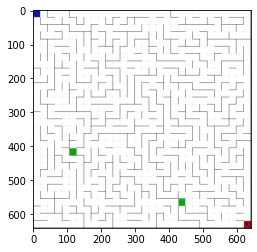

In [ ]:
env = MazeEnvSample30x30() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
print(done)
iter = 0
while not done:
  iter +=1
  state = env.state.astype(int)
  max_indices = np.argwhere(np.max(QL2.best_Q[state[0], state[1],:]) == QL2.best_Q[state[0], state[1],:])
  max_indices = np.reshape(max_indices, (max_indices.shape[0],))
  action = int(np.random.choice(max_indices))
  actual_move = stochastic_move(action)
  observation, reward, done, _ = env.step(actual_move)

  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

In [ ]:
env.close()
show_video()

**Final 500 episodes**

In [ ]:
QL2.run_episode(500)

Episode number: 0
Reached to final point, number of iterations:77
Episode number: 1
Reached to final point, number of iterations:87
Episode number: 2
Reached to final point, number of iterations:92
Episode number: 3
Reached to final point, number of iterations:77
Episode number: 4
Reached to final point, number of iterations:88
Episode number: 5
Reached to final point, number of iterations:95
Episode number: 6
Reached to final point, number of iterations:92
Episode number: 7
Reached to final point, number of iterations:83
Episode number: 8
Reached to final point, number of iterations:82
Episode number: 9
Reached to final point, number of iterations:76
Episode number: 10
Reached to final point, number of iterations:111
Episode number: 11
Reached to final point, number of iterations:83
Episode number: 12
Reached to final point, number of iterations:99
Episode number: 13
Reached to final point, number of iterations:82
Episode number: 14
Reached to final point, number of iterations:81
Epis

iteration: 75, action: 1,  observation: [29 29], reward: 2, done: True


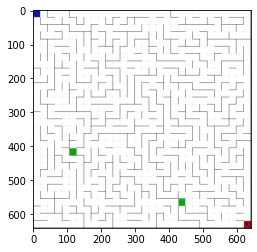

In [ ]:
env = MazeEnvSample30x30() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
print(done)
iter = 0
while not done:
  iter +=1
  state = env.state.astype(int)
  max_indices = np.argwhere(np.max(QL2.best_Q[state[0], state[1],:]) == QL2.best_Q[state[0], state[1],:])
  max_indices = np.reshape(max_indices, (max_indices.shape[0],))
  action = int(np.random.choice(max_indices))
  actual_move = stochastic_move(action)
  observation, reward, done, _ = env.step(actual_move)

  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

In [ ]:
env.close()
show_video()

**Convergence graph**

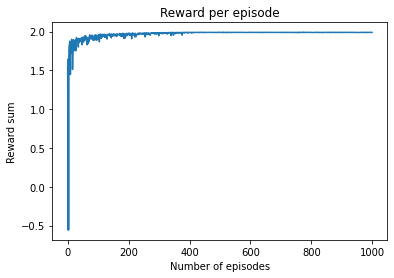

In [ ]:
episodes = [i for i in range(len(QL2.rewards))]
plt.plot(episodes, QL2.rewards)
plt.plot()

plt.xlabel("Number of episodes")
plt.ylabel("Reward sum")
plt.title("Reward per episode")
plt.show()